In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

sns.set_palette(palette="Reds")

In [2]:
n, m = 500, 2

w_true = np.random.standard_normal(m)

X = np.random.uniform(-5, 5, (n, m))
X *= (np.arange(m) * 2 + 1)[np.newaxis, :]

y = X.dot(w_true) + np.random.normal(0, 1, (n))

[Text(0.5, 0, 'X[0]'), Text(0, 0.5, 'X[1]')]

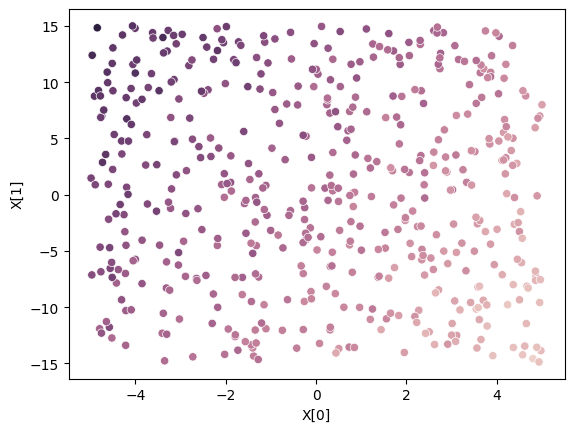

In [3]:
g = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
g.legend_.remove()
g.set(xlabel="X[0]", ylabel="X[1]")

In [4]:
def plot_weight_levels(X, y, w_history: np.ndarray):
    w1_vals = np.linspace(min(w_history[:, 0]) - 1, max(w_history[:, 0]) + 1, 100)
    w2_vals = np.linspace(min(w_history[:, 1]) - 1, max(w_history[:, 1]) + 1, 100)
    
    W1, W2 = np.meshgrid(w1_vals, w2_vals)
    J_vals = np.zeros_like(W1)

    for i in range(len(w1_vals)):
        for j in range(len(w2_vals)):
            w_tmp = np.array([W1[i, j], W2[i, j]])
            J_vals[i, j] = np.mean((X.dot(w_tmp) - y) ** 2) / 2

    plt.figure(figsize=(12, 8))
    plt.contour(W1, W2, J_vals, levels=30, cmap='viridis')

    plt.plot(w_history[:, 0], w_history[:, 1], marker='o', linestyle='-', color='red', label='Gradient Descent Trajectory')
    plt.scatter(w_history[-1][0], w_history[-1][1], marker='*', s=200, color='black', label='Final Point')

    plt.title('Weight Levels and Gradient Descent Trajectory')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.legend()
    plt.show()

In [5]:
def generate_batch(X, y, batch_size):
    """ Генератор для получения батча из данных """
    for i in range(0, len(X), batch_size):
        yield X[i : i + batch_size], y[i : i + batch_size]

## Посмотрим на стандартный SGD

In [6]:
def stochastic_gradient_descent(
    epochs: int, 
    batch_size: int, 
    alpha: float, 
    X: np.ndarray, 
    y: np.ndarray, 
    w = None,
    max_iters=1000
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Функция для оптимизации весов с помощью стохастического градиентного спуска

    Args:
        epochs (int): количество эпох
        batch_size (int): размер батча
        alpha (float): длина шага
        X (np.ndarray): Матрица объектов-признаков
        y (np.ndarray): Вектор таргетов
        w (_type_, optional): Начальное значение для вектора весов. Defaults to None.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Возвращает полученные веса, вектор с историей весов и вектор с ошибками ответов модели на каждой итерации
    """
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)

    w_cur = w.copy()
    w_history = [w_cur.copy()]
    err_history = []
    n_iter = 0
    for _ in range(epochs):
        p = np.random.permutation(len(X)) # случайно перемешиваем выборку
        batch_generator = generate_batch(X[p], y[p], batch_size)  # инициализируем генератор

        for X_batch, y_batch in batch_generator:  # Итерируемся по полученными батчам
            y_pred = X_batch.dot(w_cur)
            err = y_pred - y_batch
            grad = 2 * X_batch.T.dot(err) / n
            w_cur -= alpha * grad

            w_history.append(w_cur.copy())
            err_history.append(err.mean())
            n_iter += 1
            if n_iter == max_iters:
                 return w, np.array(w_history), np.array(err_history)

    return w, np.array(w_history), np.array(err_history)

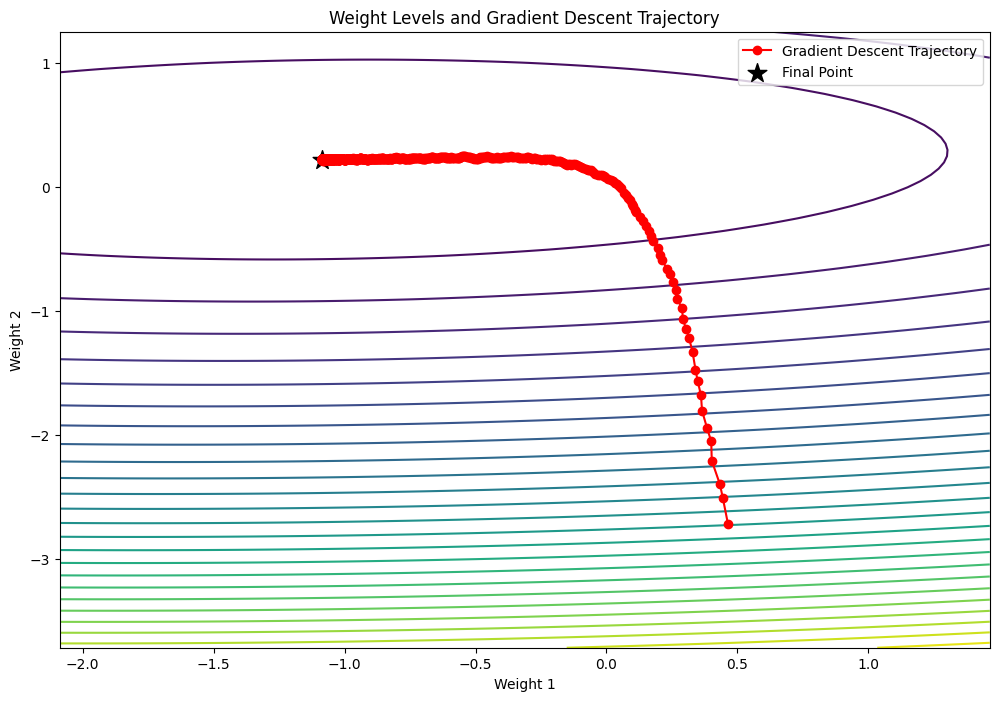

In [7]:
sgd_w, sgd_w_history, sgd_err = stochastic_gradient_descent(100, 20, 1e-2, X, y, max_iters=1000)
plot_weight_levels(X, y, sgd_w_history)

## Momentum

In [8]:
def momentum(
    epochs: int, 
    batch_size: int, 
    alpha: float,
    gamma: float, 
    X: np.ndarray, 
    y: np.ndarray, 
    w = None,
    max_iters=1000
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Функция для оптимизации весов с помощью стохастического градиентного спуска

    Args:
        epochs (int): количество эпох
        batch_size (int): размер батча
        alpha (float): длина шага
        X (np.ndarray): Матрица объектов-признаков
        y (np.ndarray): Вектор таргетов
        w (_type_, optional): Начальное значение для вектора весов. Defaults to None.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Возвращает полученные веса, вектор с историей весов и вектор с ошибками ответов модели на каждой итерации
    """
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)

    w_cur = w.copy()
    w_history = [w_cur.copy()]
    err_history = []
    velocities = []
    n_iter = 0
    for _ in range(epochs):
        p = np.random.permutation(len(X)) # случайно перемешиваем выборку
        batch_generator = generate_batch(X[p], y[p], batch_size)  # инициализируем генератор

        for X_batch, y_batch in batch_generator:  # Итерируемся по полученными батчам
            y_pred = X_batch.dot(w_cur)
            err = y_pred - y_batch
            grad = 2 * X_batch.T.dot(err) / n
            
            if n_iter > 0:
                velocities.append(gamma * velocities[-1] + alpha * grad)
            else:
                velocities.append(grad)

            w_cur = w_history[-1] - velocities[-1]

            w_history.append(w_cur.copy())
            err_history.append(err.mean())
            n_iter += 1
            if n_iter == max_iters:
                 return w, np.array(w_history), np.array(err_history)

    return w, np.array(w_history), np.array(err_history)

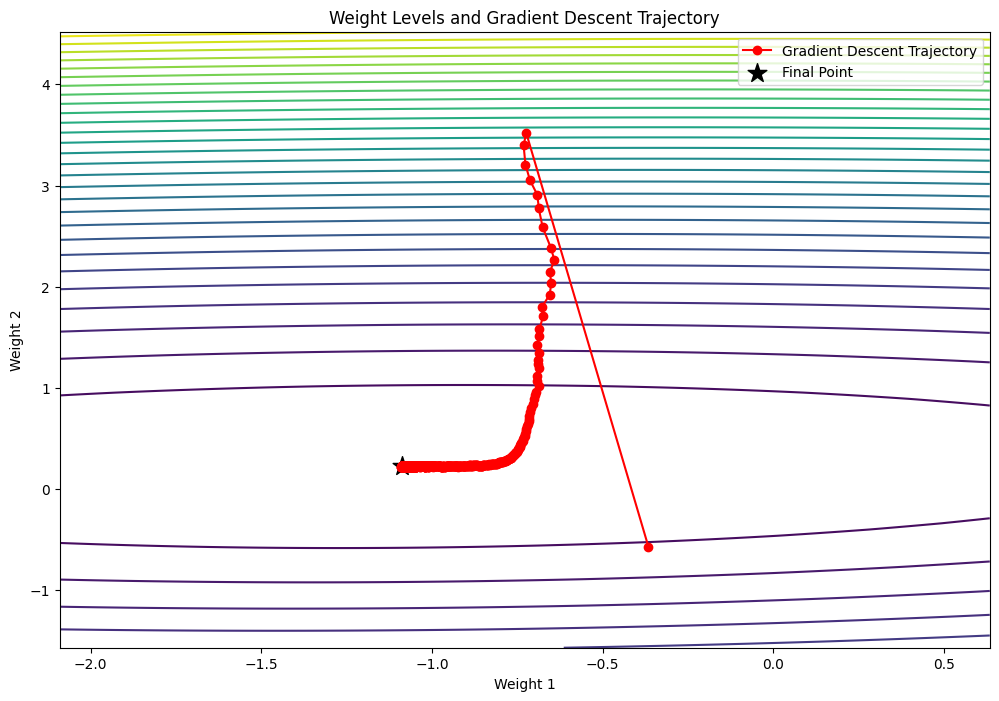

In [9]:
moment_w, moment_w_history, moment_err = momentum(100, 20, 1e-2, 0.01, X=X, y=y, max_iters=1000)
plot_weight_levels(X, y, moment_w_history)

## RMSprop

In [10]:
def rmsprop(
    epochs: int, 
    batch_size: int, 
    alpha: float,
    gamma: float, 
    X: np.ndarray, 
    y: np.ndarray, 
    eps: float = 1e-8,
    w = None,
    max_iters=1000
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Функция для оптимизации весов с помощью стохастического градиентного спуска

    Args:
        epochs (int): количество эпох
        batch_size (int): размер батча
        alpha (float): длина шага
        X (np.ndarray): Матрица объектов-признаков
        y (np.ndarray): Вектор таргетов
        w (_type_, optional): Начальное значение для вектора весов. Defaults to None.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Возвращает полученные веса, вектор с историей весов и вектор с ошибками ответов модели на каждой итерации
    """
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)

    w_cur = w.copy()
    w_history = [w_cur.copy()]
    err_history = []
    G = []
    n_iter = 0
    for _ in range(epochs):
        p = np.random.permutation(len(X)) # случайно перемешиваем выборку
        batch_generator = generate_batch(X[p], y[p], batch_size)  # инициализируем генератор

        for X_batch, y_batch in batch_generator:  # Итерируемся по полученными батчам
            y_pred = X_batch.dot(w_cur)
            err = y_pred - y_batch
            grad = 2 * X_batch.T.dot(err) / n

            if n_iter > 0:
                G.append(gamma * G[-1] + (1 - gamma) * grad**2)
            else:
                G.append(abs(grad))

            w_cur = w_history[-1] - alpha * grad / np.sqrt(G[-1] + eps) 

            w_history.append(w_cur.copy())
            err_history.append(err.mean())
            n_iter += 1
            if n_iter == max_iters:
                 return w, np.array(w_history), np.array(err_history)

    return w, np.array(w_history), np.array(err_history)

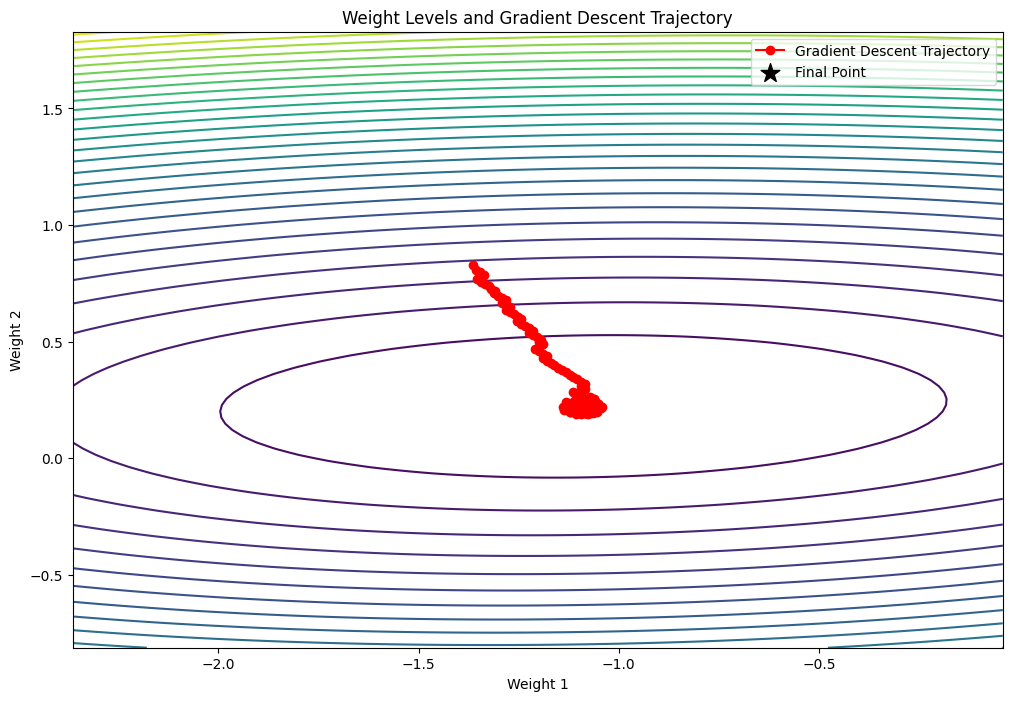

In [11]:
rmsprop_w, rmsprop_w_history, rmsprop_err = rmsprop(100, 20, 1e-2, 1e-2, X, y, max_iters=1000)
plot_weight_levels(X, y, rmsprop_w_history)

## Adam

In [12]:
def Adam(
    epochs: int, 
    batch_size: int, 
    alpha: float,
    X: np.ndarray, 
    y: np.ndarray, 
    betas: tuple = (0.9, 0.99),
    eps: float = 1e-8,
    w = None,
    max_iters=1000
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Функция для оптимизации весов с помощью стохастического градиентного спуска

    Args:
        epochs (int): количество эпох
        batch_size (int): размер батча
        alpha (float): длина шага
        X (np.ndarray): Матрица объектов-признаков
        y (np.ndarray): Вектор таргетов
        w (_type_, optional): Начальное значение для вектора весов. Defaults to None.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Возвращает полученные веса, вектор с историей весов и вектор с ошибками ответов модели на каждой итерации
    """
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)

    w_cur = w.copy()
    w_history = [w_cur.copy()]
    err_history = []
    velocities = []
    G = []
    n_iter = 0
    for _ in range(epochs):
        p = np.random.permutation(len(X)) # случайно перемешиваем выборку
        batch_generator = generate_batch(X[p], y[p], batch_size)  # инициализируем генератор

        for X_batch, y_batch in batch_generator:  # Итерируемся по полученными батчам
            y_pred = X_batch.dot(w_cur)
            err = y_pred - y_batch
            grad = 2 * X_batch.T.dot(err) / n
            
            if n_iter > 0:
                velocities.append(betas[0] * velocities[-1] + (1 - betas[0]) * grad)
                G.append(betas[1] * G[-1] + (1 - betas[1]) * grad**2)
            else:
                velocities.append(grad)
                G.append(abs(grad))

            w_cur = w_history[-1] - alpha * velocities[-1] / np.sqrt(G[-1] + eps)
            w_history.append(w_cur.copy())
            err_history.append(err.mean())
            n_iter += 1
            if n_iter == max_iters:
                 return w, np.array(w_history), np.array(err_history)

    return w, np.array(w_history), np.array(err_history)

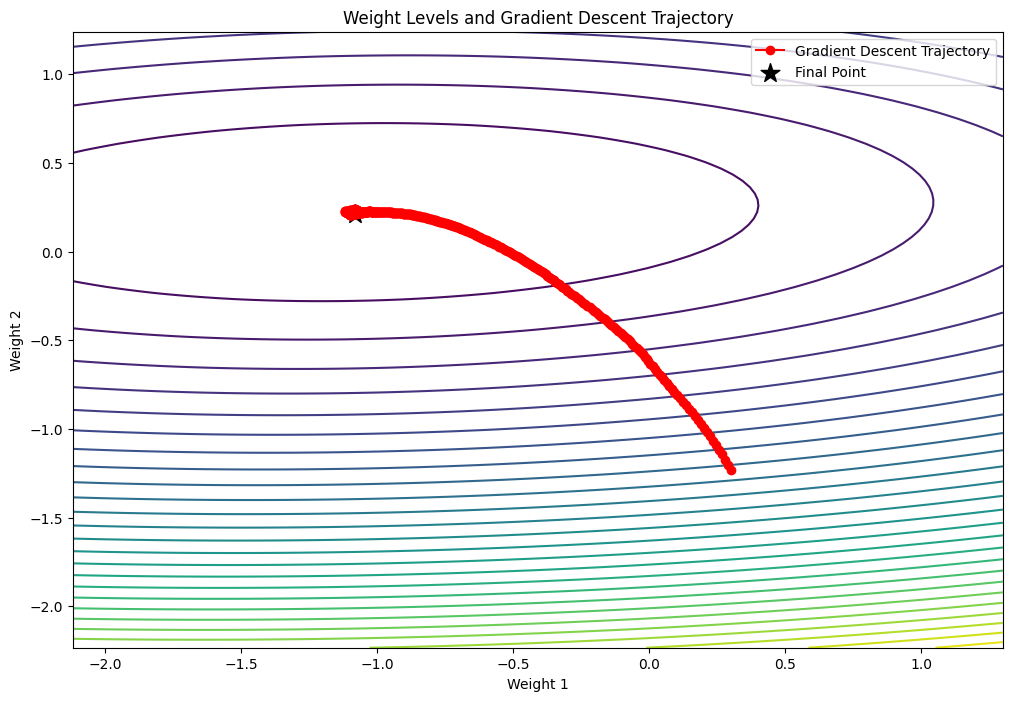

In [13]:
adam_w, adam_w_history, adam_err = Adam(100, 20, 1e-2, X, y)
plot_weight_levels(X, y, adam_w_history)

## Запустим все методы на новых данных

In [19]:
n, m = 5000, 2

w_true = np.random.standard_normal(m)

X = np.random.uniform(-5, 5, (n, m))
X *= (np.arange(m) * 2 + 1)[np.newaxis, :]

y = X.dot(w_true) + np.random.normal(0, 1, (n))

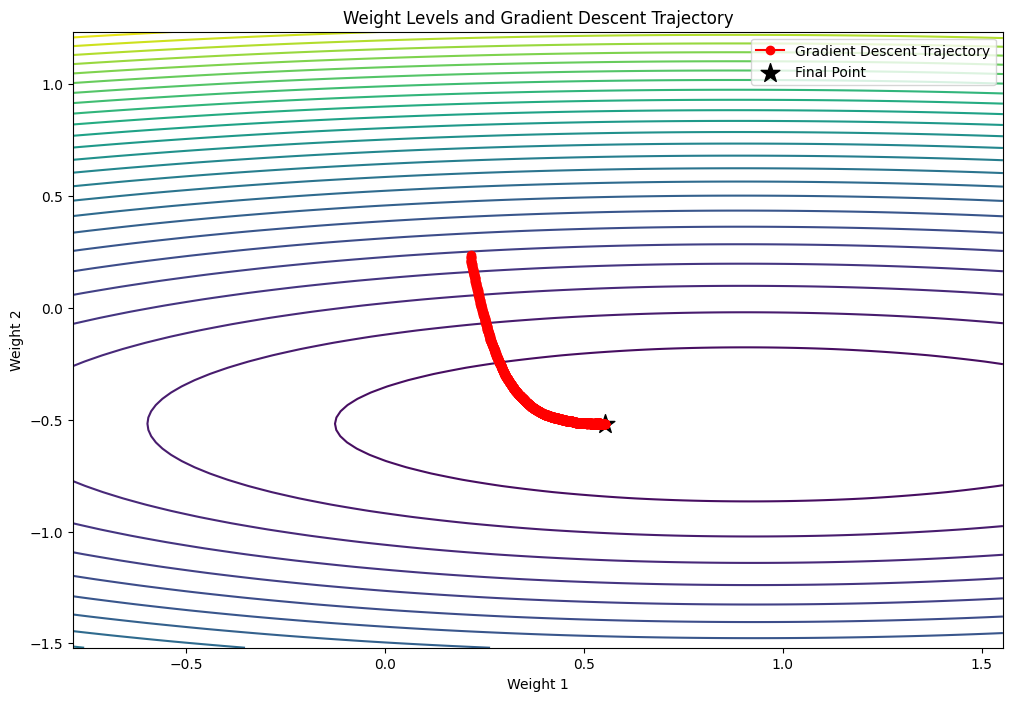

In [20]:
sgd_w, sgd_w_history, sgd_err = stochastic_gradient_descent(100, 20, 1e-2, X, y, max_iters=1000)
plot_weight_levels(X, y, sgd_w_history)

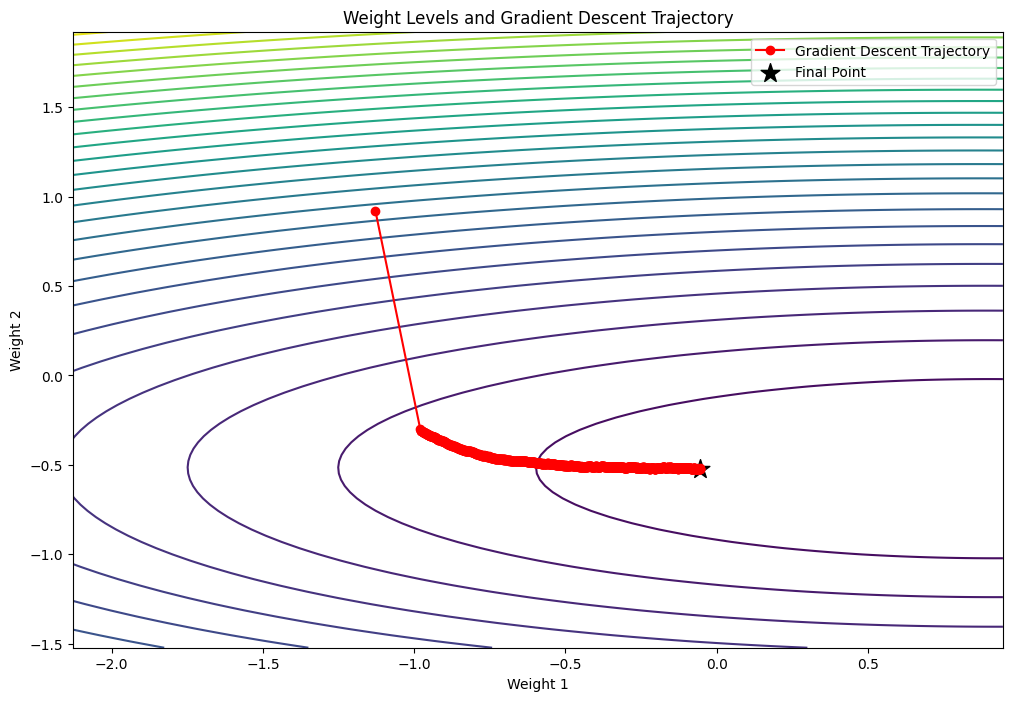

In [21]:
moment_w, moment_w_history, moment_err = momentum(100, 20, 1e-2, 0.01, X=X, y=y, max_iters=1000)
plot_weight_levels(X, y, moment_w_history)

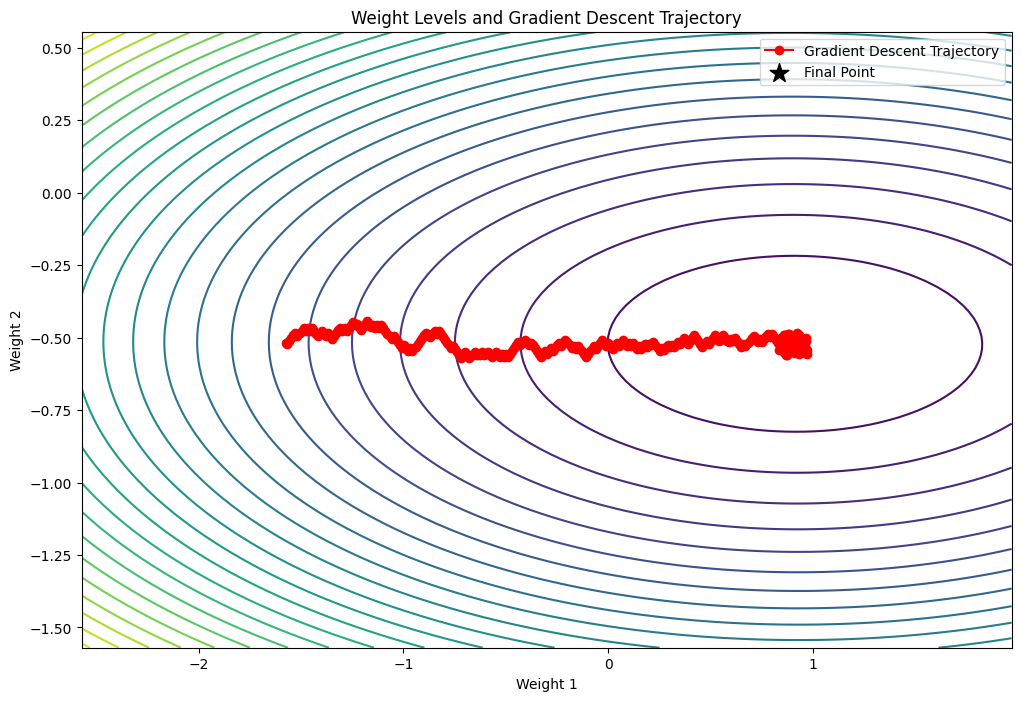

In [22]:
rmsprop_w, rmsprop_w_history, rmsprop_err = rmsprop(100, 20, 1e-2, 1e-2, X, y, max_iters=1000)
plot_weight_levels(X, y, rmsprop_w_history)

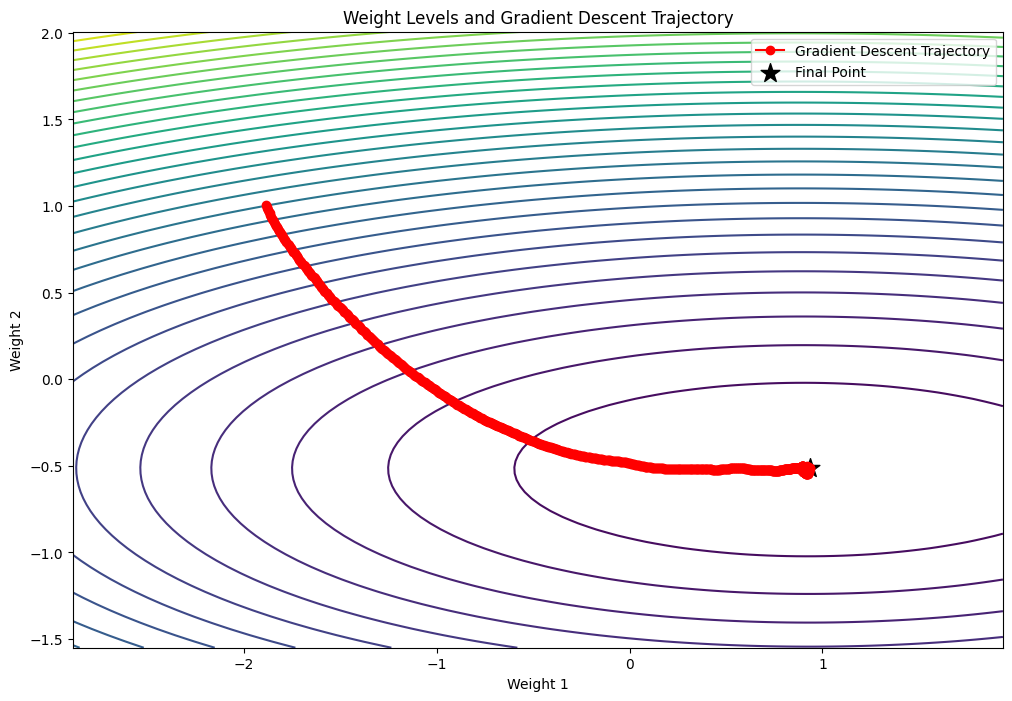

In [23]:
adam_w, adam_w_history, adam_err = Adam(100, 20, 1e-2, X, y)
plot_weight_levels(X, y, adam_w_history)

## Сравнение скорости сходимости 

In [24]:
def plot_convergence(sgd, momentum, rmsprop, adam):
    plt.figure(figsize=(10, 6))
    
    plt.plot(sgd, label='Sgd', color='blue')
    plt.plot(momentum, label='Momentum', color='red')
    plt.plot(rmsprop, label='rmsprop', color='green')
    plt.plot(adam, label='Adam', color='black')
    plt.title('Convergence Comparison')
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()

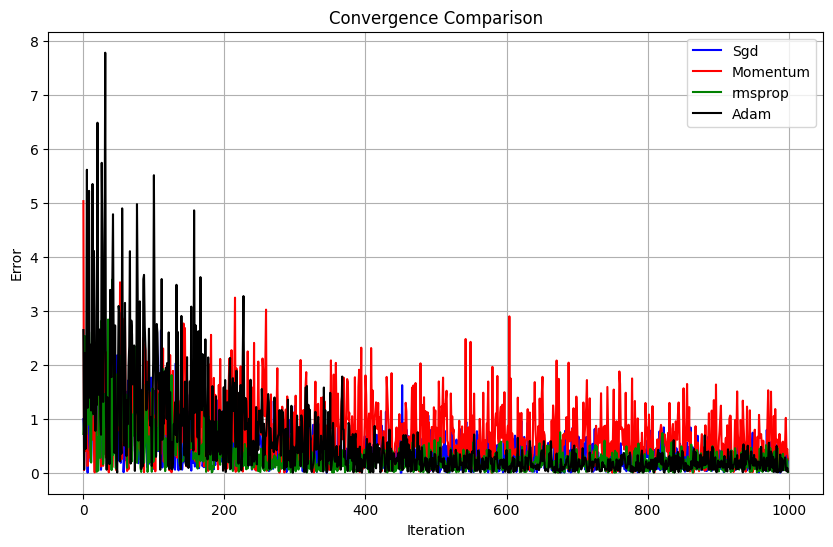

In [25]:
plot_convergence(abs(sgd_err), abs(moment_err), abs(rmsprop_err), abs(adam_err))

Сделаем выводы:
\
Решая оптимизацию в общем случае, не подбирая лучшие параметры для каждого из методов, было замечено, что самыми оптимальными методами оказались sgd и Adam. Momentum не справился с оптимизацией 5000 samples, в свою очередь rmsprop быстро сошел к окрестностям оптимума, где сильно зашумился.
